## Obejective
- Create a streamlit app to predict california house price

## Info
- Ref: https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb
- Column Description
    - longitude: A measure of how far west a house is; a higher value is farther west
    - latitude: A measure of how far north a house is; a higher value is farther north
    - housingMedianAge: Median age of a house within a block; a lower number is a newer building
    - totalRooms: Total number of rooms within a block
    - totalBedrooms: Total number of bedrooms within a block
    - population: Total number of people residing within a block
    - households: Total number of households, a group of people residing within a home unit, for a block
    - medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
    - medianHouseValue: Median house value for households within a block (measured in US Dollars)
    - oceanProximity: Location of the house w.r.t ocean/sea

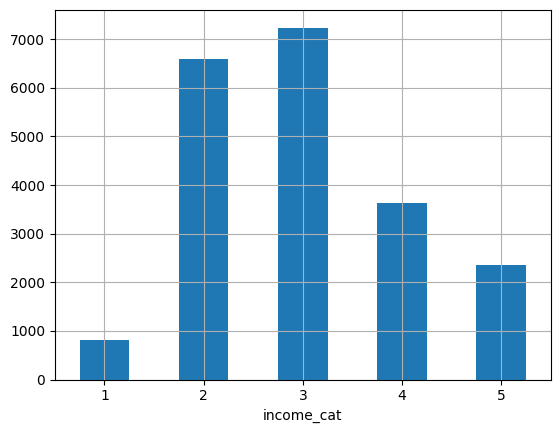

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('housing.csv')


# df = pd.read_csv('housing.csv')
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

df["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.show()

In [2]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, stratify=df['income_cat'], random_state=20240417)
## Check stratification
train['income_cat'].value_counts() / len(train['income_cat'])
test['income_cat'].value_counts() / len(test['income_cat'])

income_cat
3    0.350568
2    0.318868
4    0.176287
5    0.114480
1    0.039798
Name: count, dtype: float64

income_cat
3    0.350614
2    0.318798
4    0.176357
5    0.114341
1    0.039890
Name: count, dtype: float64

In [3]:
corr_matrix = train.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.686455
total_rooms           0.129861
housing_median_age    0.105019
households            0.067089
total_bedrooms        0.050168
population           -0.022726
longitude            -0.048416
latitude             -0.143447
Name: median_house_value, dtype: float64

Text(0.5, 1.0, 'Correlation Plot')

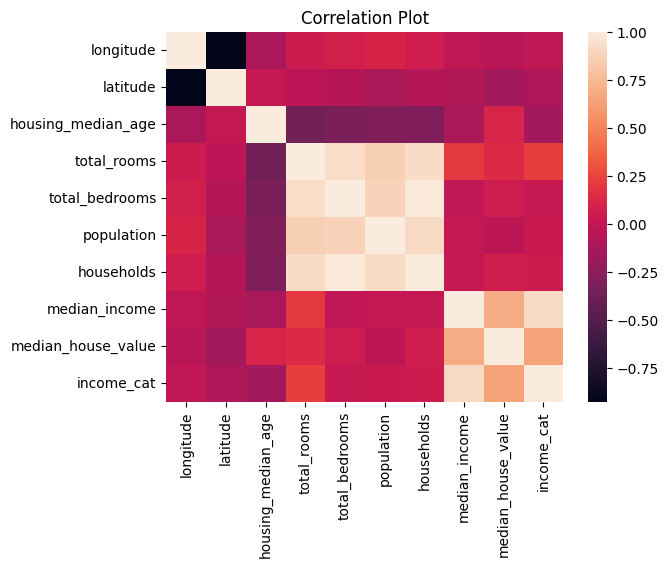

In [4]:
import seaborn as sns 
sns.heatmap(df.select_dtypes(exclude='object').corr()).set_title('Correlation Plot')


Text(0.5, 1.0, 'Ocean Proximity Analysis for Median House Value')

<Axes: title={'center': 'Ocean Proximity Analysis for Median House Value'}, xlabel='ocean_proximity', ylabel='median_house_value'>

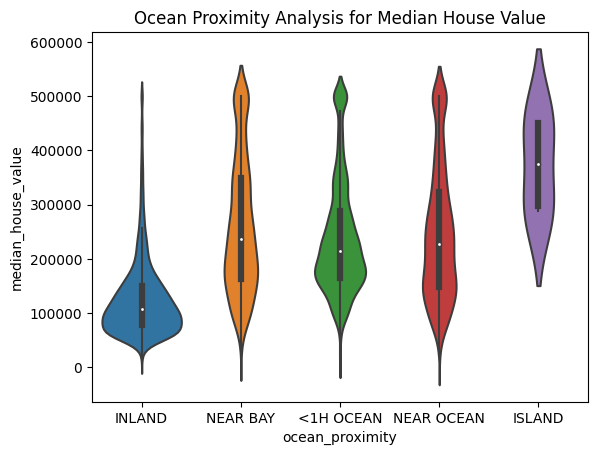

In [5]:
plt.title('Ocean Proximity Analysis for Median House Value')
sns.violinplot(x='ocean_proximity', y='median_house_value', data=train)
plt.show()

In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class Preprocessor(BaseEstimator, TransformerMixin): 
    # Train our custom preprocessors 
    numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', ]
    categorical_columns = ['ocean_proximity', 'income_cat']
    
    def fit(self, X, y=None): 

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])
        
        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 
        
        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])
        
        return self 

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equiv
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [7]:
X_train = train.drop('median_house_value', axis=1)
y_train = train['median_house_value']
preproc = Preprocessor()
preproc.fit(X_train)
preprocessed_df = preproc.transform(X_train)
preprocessed_df.head()

Preprocessor()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,income_cat_1,income_cat_2,income_cat_3,income_cat_4,income_cat_5
9119,-0.723636,1.691333,1.859908,-0.495041,-0.617497,-0.728593,-0.648757,-0.863695,0,1,0,0,0,0,1,0,0,0
2023,-1.393375,1.087701,0.191558,-0.671639,-0.615171,-0.416972,-0.692475,-1.227802,0,0,0,1,0,0,1,0,0,0
12868,-0.483730,-0.311415,-0.444004,-0.583340,-0.454719,-0.092957,-0.425020,-1.078713,1,0,0,0,0,0,1,0,0,0
3943,-0.868579,1.373140,-0.523449,-0.639202,-0.668655,-0.614391,-0.646185,-0.720700,0,1,0,0,0,0,1,0,0,0
9538,-1.563308,1.214043,1.462682,-0.251319,-0.357052,-0.331099,-0.319580,-0.160014,1,0,0,0,0,0,0,1,0,0


In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
rfr = make_pipeline(Preprocessor(), RandomForestRegressor())
rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestregressor', RandomForestRegressor())])

In [9]:
from sklearn.metrics import root_mean_squared_error
y_train_hat=rfr.predict(X_train)
root_mean_squared_error(y_train, y_train_hat)

18307.5772470693

In [10]:
X_test = test.drop('median_house_value', axis=1)
y_test = test['median_house_value']
y_test_hat=rfr.predict(X_test)
root_mean_squared_error(y_test, y_test_hat)

48699.68053985501

In [11]:
import dill
with open('rfr_v1.pkl', 'wb') as f:
    dill.dump(rfr, f)

In [13]:
options = {}
numerical_columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income', ]
for column in numerical_columns:
    options[column] = (X_train[column].min(),  X_train[column].max())
for column in ['ocean_proximity']:
    options[column] = sorted(X_train[column].unique().tolist())

model = {
    'version': '1.0',
    'name': 'RandomForestRegressor',    
    'Comments': 'Initial model',
    'model_file': 'rfr_v1.pkl',
    'options': options,
}

import json
with open('rfr_v1_info.json', 'w') as f:
    json.dump(model, f, indent=2)

In [17]:
import json
print(json.dumps(X_test.iloc[0].to_dict(), indent=2))

{
  "longitude": -121.84,
  "latitude": 36.94,
  "housing_median_age": 29.0,
  "total_rooms": 4921.0,
  "total_bedrooms": 967.0,
  "population": 2319.0,
  "households": 823.0,
  "median_income": 4.9517,
  "ocean_proximity": "NEAR OCEAN",
  "income_cat": 4
}


In [23]:
import requests
for index, row in X_test.iterrows():
    data = json.dumps(row.to_dict(), indent=2)
    r = requests.post('http://127.0.0.1:8000/', data=data)
    print(index, r.json())

5985 {'prediction': 286998.0}
17936 {'prediction': 280253.03}
19104 {'prediction': 155208.0}
15194 {'prediction': 140743.0}
8327 {'prediction': 114046.0}
16703 {'prediction': 499482.95}
19539 {'prediction': 236264.02}
2058 {'prediction': 97718.0}
10806 {'prediction': 363161.11}
4212 {'prediction': 146734.0}
12826 {'prediction': 76910.0}
19445 {'prediction': 490732.9}
8883 {'prediction': 234851.0}
10325 {'prediction': 186480.0}
8631 {'prediction': 117600.0}
11985 {'prediction': 117448.0}
15207 {'prediction': 172536.0}
320 {'prediction': 175479.0}
6405 {'prediction': 284483.02}
3747 {'prediction': 49856.0}
14098 {'prediction': 365390.02}
9036 {'prediction': 300471.01}
18973 {'prediction': 118790.0}
1856 {'prediction': 251279.0}
14245 {'prediction': 219743.0}
2237 {'prediction': 500001.0}
7867 {'prediction': 196041.0}
751 {'prediction': 137254.0}
9300 {'prediction': 154739.0}
12073 {'prediction': 180845.0}
16918 {'prediction': 239348.0}
13773 {'prediction': 274279.0}
17947 {'prediction': 

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [21]:
r.json()

{'prediction': 286998.0}

In [80]:
import json
print(json.dumps(X_test.iloc[0].to_dict(), indent=2))

{
  "longitude": -121.84,
  "latitude": 36.94,
  "housing_median_age": 29.0,
  "total_rooms": 4921.0,
  "total_bedrooms": 967.0,
  "population": 2319.0,
  "households": 823.0,
  "median_income": 4.9517,
  "ocean_proximity": "NEAR OCEAN",
  "income_cat": 4
}


In [72]:
import dill
with open('rfr_v1.pkl', 'rb') as f:
    reloaded_model = dill.load(f)

df = pd.read_csv('housing.csv')
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']
y_hat = reloaded_model.predict(X)
root_mean_squared_error(y, y_hat)

30906.37371846427

In [55]:
import joblib
with open('streamlit_app/rfr_v1.pkl', 'wb') as f:
    joblib.dump(rfr, f, compress=9)

In [56]:
with open('streamlit_app/rfr_v1.pkl', 'rb') as f:
    r_model = joblib.load(f)

df = pd.read_csv('housing.csv')
df["income_cat"] = pd.cut(df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
X = df.drop(['median_house_value'], axis=1)
y = df['median_house_value']
y_hat = reloaded_model.predict(X)
root_mean_squared_error(y, y_hat)

30906.37371846427

In [29]:
rfr.steps[1][1].feature_names_in_

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN', 'income_cat_1', 'income_cat_2',
       'income_cat_3', 'income_cat_4', 'income_cat_5'], dtype=object)

In [63]:
regressor = rfr.steps[1][1]


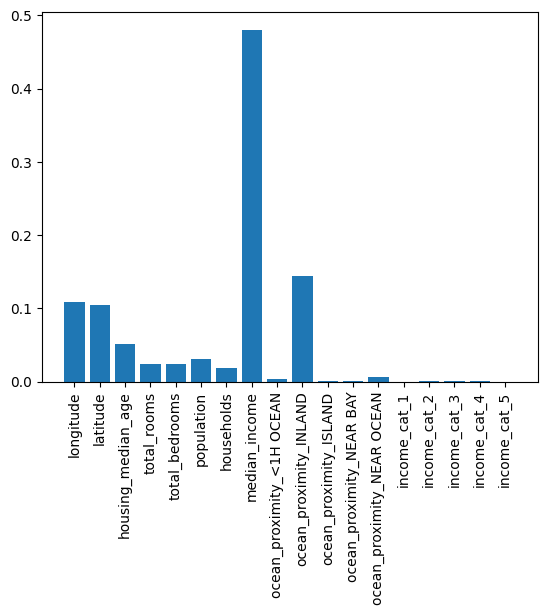

In [70]:
_ = plt.bar(regressor.feature_names_in_, regressor.feature_importances_)
_ = plt.xticks(rotation=90)

In [83]:
X_test = test.drop('median_house_value', axis=1)
y_test = test['median_house_value']
X_test['population'] = X_test['population']/10
X_test['median_income'] = X_test['median_income']/10

In [84]:
X_test.to_pickle('drop10.pkl')

In [86]:
pd.read_pickle('drop10.pkl')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
5985,-121.84,36.94,29.0,4921.0,967.0,231.9,823.0,4.9517,NEAR OCEAN,4
17936,-117.16,32.74,43.0,1437.0,406.0,69.2,379.0,3.1979,NEAR OCEAN,3
19104,-117.06,32.76,38.0,1549.0,288.0,63.6,278.0,3.2188,NEAR OCEAN,3
15194,-118.31,33.94,40.0,1323.0,243.0,68.4,229.0,3.2206,<1H OCEAN,3
8327,-120.84,37.48,10.0,2874.0,612.0,196.0,596.0,2.7381,INLAND,2
...,...,...,...,...,...,...,...,...,...,...
770,-119.27,34.26,23.0,3578.0,753.0,145.5,649.0,4.1898,NEAR OCEAN,3
10180,-117.97,33.93,31.0,1975.0,373.0,91.8,347.0,4.4107,<1H OCEAN,3
10429,-122.48,37.69,42.0,2993.0,512.0,159.4,546.0,4.4821,NEAR OCEAN,3
12546,-121.44,39.50,26.0,1652.0,325.0,79.0,292.0,3.0446,INLAND,3
